In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scrape import entorb

federal_state_translation = {
    "BB": "Brandenburg",
    "BE": "Berlin",
    "BW": "Baden-Württemberg",
    "BY": "Bayern",
    "HB": "Bremen",
    "HE": "Hessen",
    "HH": "Hamburg",
    "MV": "Mecklenburg-Vorpommern",
    "NI": "Niedersachsen",
    "NW": "Nordrhein-Westfalen",
    "RP": "Rheinland-Pfalz",
    "SH": "Schleswig-Holstein",
    "SL": "Saarland",
    "SN": "Sachsen",
    "ST": "Sachsen-Anhalt",
    "TH": "Thüringen",
    "DE-total": "Deutschland",
}
inv_fst = {v: k for k, v in federal_state_translation.items()}

df = pd \
.read_csv("data/fertility_de.tsv",
          sep="\t",
          usecols=['States', 'Fertilitätsrate pro Frau'])

df['Cases_Per_Million'] = [entorb.to_dataframe(inv_fst[area])['Cases_Per_Million'].median() for area in df['States']]
display(df)
corr = df.corr()**2
corr.style.background_gradient(cmap='Blues')

,States,Fertilitätsrate pro Frau,Cases_Per_Million
0,Brandenburg,1.69,1360.0
1,Niedersachsen,1.68,1675.0
2,Sachsen,1.66,1333.0
3,Bremen,1.63,2421.0
4,Thüringen,1.63,1507.0
5,Sachsen-Anhalt,1.62,841.0
6,Nordrhein-Westfalen,1.61,2341.0
7,Schleswig-Holstein,1.61,1083.0
8,Rheinland-Pfalz,1.60,1698.0
9,Baden-Württemberg,1.59,3202.0


,Fertilitätsrate pro Frau,Cases_Per_Million
Fertilitätsrate pro Frau,1.000000,0.196465
Cases_Per_Million,0.196465,1.000000


In [2]:
from qwikidata.sparql \
import return_sparql_query_results

# https://query.wikidata.org/
dictlist = return_sparql_query_results("""
SELECT DISTINCT ?code ?population ?area ?ppp ?life_expectancy ?fertility_rate
{
  ?country wdt:P31 wd:Q3624078 ;
           wdt:P297 ?code ;
           wdt:P2046 ?area ;
           wdt:P1082 ?population .
    OPTIONAL {
           ?country wdt:P4010 ?ppp .
           ?country wdt:P2250 ?life_expectancy .
           ?country wdt:P4841 ?fertility_rate .
    }
}
""")['results']['bindings']
df = pd.DataFrame({
    k: [x[k]['value'] if k is 'code' else float(x[k]['value']) if k in x else None for x in dictlist] for k in ['code', 'population', 'area', 'ppp', 'life_expectancy', 'fertility_rate']}) \
.set_index('code')
df['density'] = df['population']/df['area']
df['p5'] = df['ppp']/df['population']

cols = ['Cases', 'Cases_New', 'Cases_Per_Million', 'Deaths', 'Deaths_New', 'Deaths_Per_Million']
dict_entorb = {c: [] for c in cols}
for area in df.index:
    try:
        for col in cols:
            dict_entorb[col].append(entorb.to_dataframe(area)[col].last('7D').mean())
    except:
        for col in cols:
            dict_entorb[col].append(None)
for col in dict_entorb:
    df[col+'_mean'] = dict_entorb[col]

In [3]:
corr = df.corr()
corr.style.background_gradient(cmap='Blues')

,population,area,ppp,life_expectancy,fertility_rate,density,p5,Cases_mean,Cases_New_mean,Cases_Per_Million_mean,Deaths_mean,Deaths_New_mean,Deaths_Per_Million_mean
population,1.000000,0.411009,0.808135,0.011165,-0.063728,-0.018549,-0.037833,-0.162451,-0.171434,-0.090613,-0.134775,-0.128250,0.030529
area,0.411009,1.000000,0.552881,0.054132,-0.091248,-0.058849,0.073203,0.439756,0.403730,0.289600,0.469977,0.595341,0.477481
ppp,0.808135,0.552881,1.000000,0.166133,-0.178755,-0.005089,0.153154,-0.101881,-0.082539,0.062692,-0.121038,-0.149097,-0.023004
life_expectancy,0.011165,0.054132,0.166133,1.000000,-0.829183,0.170695,0.667257,0.097278,0.151015,-0.065714,0.021306,0.040234,-0.443497
fertility_rate,-0.063728,-0.091248,-0.178755,-0.829183,1.000000,-0.139037,-0.550097,-0.318710,-0.292790,-0.219526,-0.284463,-0.174056,-0.052670
density,-0.018549,-0.058849,-0.005089,0.170695,-0.139037,1.000000,0.276043,-0.416398,-0.438486,-0.510409,-0.413364,-0.490200,-0.602011
p5,-0.037833,0.073203,0.153154,0.667257,-0.550097,0.276043,1.000000,0.204246,0.306595,0.462571,0.083399,0.027321,-0.072716
Cases_mean,-0.162451,0.439756,-0.101881,0.097278,-0.318710,-0.416398,0.204246,1.000000,0.977405,0.767842,0.986143,0.936728,0.732793
Cases_New_mean,-0.171434,0.403730,-0.082539,0.151015,-0.292790,-0.438486,0.306595,0.977405,1.000000,0.825356,0.933269,0.922519,0.672739
Cases_Per_Million_mean,-0.090613,0.289600,0.062692,-0.065714,-0.219526,-0.510409,0.462571,0.767842,0.825356,1.000000,0.696699,0.627140,0.771122


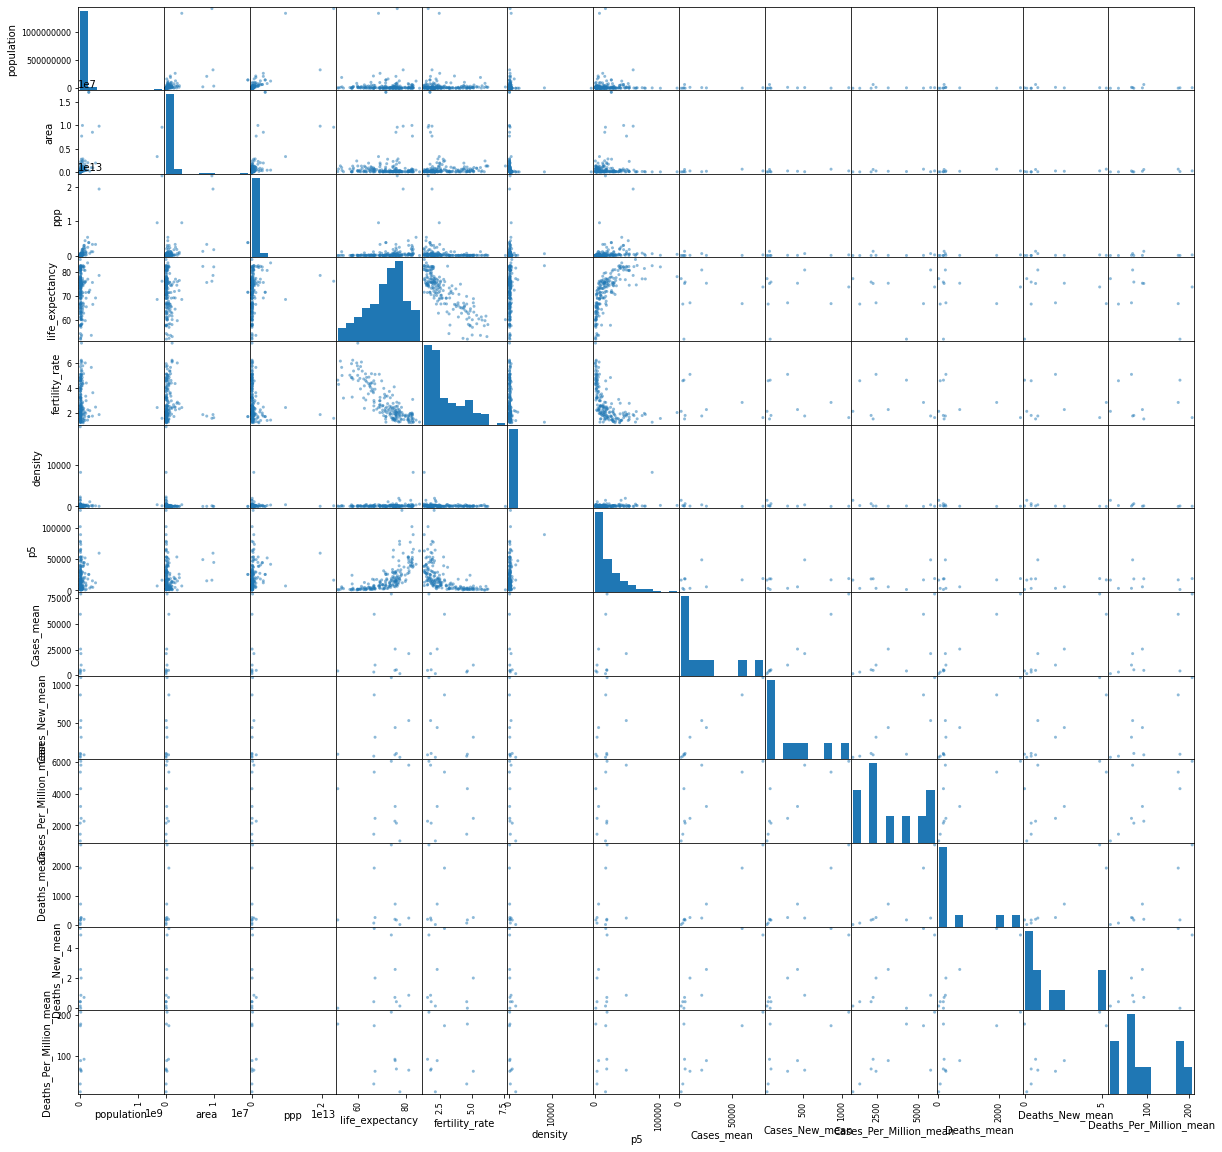

In [4]:
axes = pd.plotting.scatter_matrix(df, figsize=(20,20))